# **Table of contents**
#### **Github & Onedrive Links**

#### **Outline**
- Problem Definition
  *   Purpose
- Structure 

   
#### **Dataset**
- Training and Validation
- Development dataset -> Transfer learning 

#### **Data visualization**
- Calculate statistics in dataset
- Visualize Spectrograms

#### **Preprocessing**
#### **AudioNet Base Structure**
- Training function and training commands
- Results
- Test of Librispeech test dataset

#### **Transfer Learning with VoxCeleb dataset**
- Train with transfer learnt model
- Results

#### **Discussion**

### Students:


*   Renzo Benavides Valdiviezo

*   Ye Wang
*   William Hazen


*   Hanxing Yu



In [ ]:
import copy
import time
import os
sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from math import floor

from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import read_pickled_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GitHub & Onedrive Links

## GitHub

Please access though the link below for our repository on GitHub, it includes all the helper codes in SRC folder. 
https://github.com/renzo-b/audio-speaker-recognition

## Onedrive

Please access though the link below for pickled data used in this project. https://1drv.ms/u/s!AmYq9m5Um8eJjJwQV8lNwdhCJC53RQ?e=YkRUHx


# Outline

## Problem definition

The project is to recognize speaker using audio data using deep neural network. Audio speaker recognition can be used under many scenarios if implemented properly. For example, at home, it can be used on smart speaker to verify who is it talking to before giving out any private information (such as agenda, purchasing histroy, and SIN). In a business setting, it can be used to identify speaker in a large conference.  

### Purpose

The purpose of the project consists of being able to identify a speaker based on audio samples. The expectation of a working model (AudioNet) is to be able to validate a speaker in real time. However, if one was to implement AudioNet for a large conference, the AudioNet must be trained on a variatey of different audio samples, such that given a new audio sample, the model should identify which of the speakers it belongs to. The underlying purpose of this project is to validate that this process can be done.

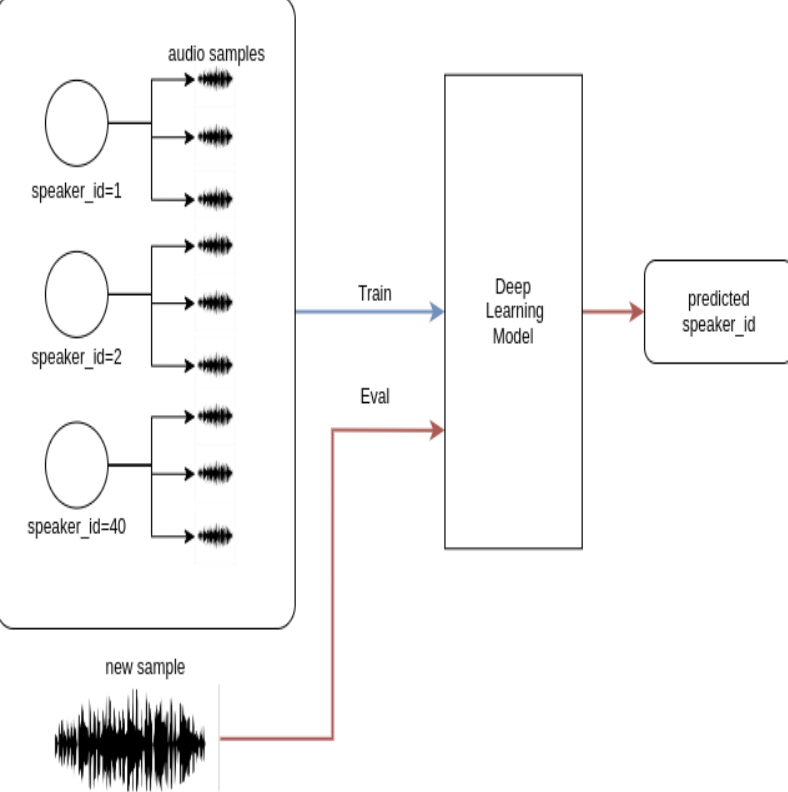

## Project structure

To note, the project was split into two parts.
1. The first part was the model creation and training, where the given model was trained on large sets of data, being audio files with different speakers.
2. The second part was focused on validation. This was where testing was conducted to see how the model can perform on new data.   


# Dataset

---


We started with Librispeech as it provides hours of recorded audio samples in relatively noise-free environments. 

### Training and validation
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

There are multiple sizes of the dataset. In this notebook we are using **train-clean-100 and train-other-500** to train our model.

In [ ]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100

 Done downloading


### Development dataset --> transfer learning

After that, we used celebrities audio data for transfer learning. We used VoxCeleb dataset and voices from celebrities recorded from youtube as the development/validation set. 

# Data Visualization

The data extract from librispeech includes audio samples recorded as waveforms. In audio processing algorithm, it is standard practice to extract data by transforming the waveforms into a spectrogram or a varation of a spectrogram called a Mel-frequency cepstrum (MFC). This is done to remove unnecessary data from the waveforms and keep important information such as time, frequency, and amplitude.   

waveform:  tensor([[0.0004, 0.0007, 0.0010,  ..., 0.0005, 0.0020, 0.0013]])
sample_rate:  16000
transcript:  DOCTOR FRANK AND HER BROTHER ARE WITH HER THEY'RE DOING ALL THEY CAN HE TOLD US WHAT HAD HAPPENED ANITA AND GEORGE PRINCE HAD BOTH BEEN ASLEEP EACH IN HIS RESPECTIVE ROOM SOMEONE UNKNOWN
speaker_id:  2436


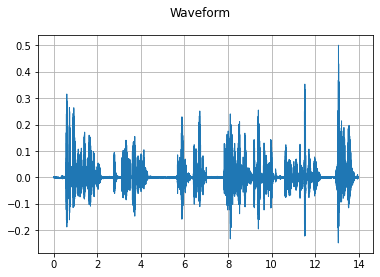

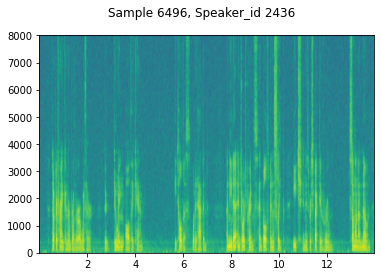

In [ ]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [ ]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []
waveforms = []
transcripts = []

for i in tqdm(range(dataset.__len__())):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    speaker_ids.append(speaker_id)

    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    waveforms.append(waveform[0].numpy())
    transcripts.append(transcript)
    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

 52%|█████▏    | 14766/28539 [01:38<01:28, 156.32it/s]

Dataset has 28539 samples
Random samples has shape: torch.Size([1, 225360])
Unique speaker ids: 251


waveform_lengths  sample_rates  transcript_lengths  audio_durations
min           22560.0       16000.0                 8.0              1.0
std           57194.0           0.0                59.0              4.0
min           22560.0       16000.0                 8.0              1.0
max          392400.0       16000.0               398.0             25.0

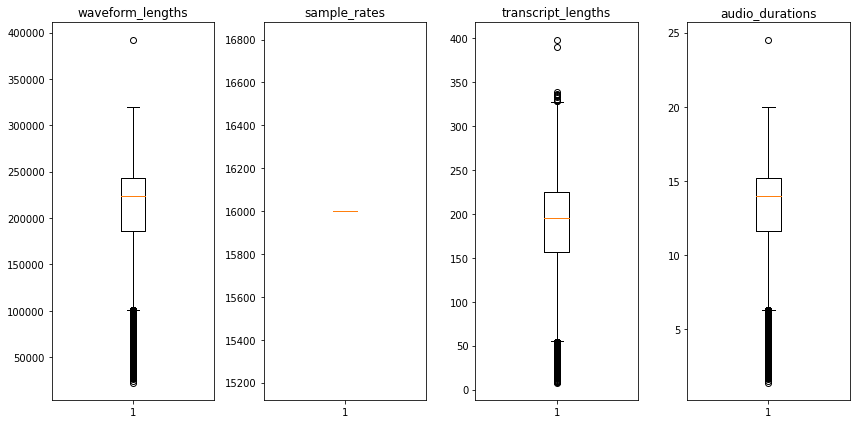

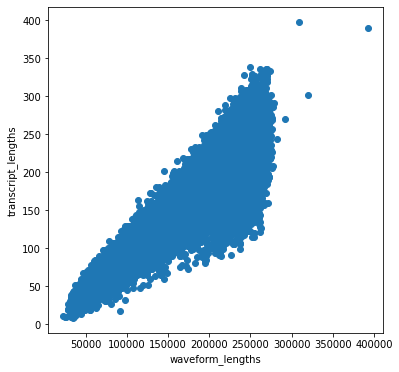

In [ ]:
df = calculate_statistics(dataset)

We can see from the above charts that there is a lot of variance in the audio duration. Our model needs to take consistent sizes of audio.

In [ ]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

In [ ]:
df_spkr.to_csv('df_speaker_ids.csv')
df_spkr = pd.read_csv('df_speaker_ids.csv')

In [ ]:
df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

duration
speaker_id           
3752         4.788218
2277         5.057843
6313         5.105885
1462         5.129628
3081         5.335724
2428         5.528563
5694         5.790181
777          5.898658
5895         6.016188
6241         6.191476
7976         6.255321
6345         6.290779
2035         6.315715
251          6.429134
8297         6.434202
6295         6.517703
1988         6.525133
1272         6.589519
7850         6.716529
652          7.022817
84           7.403845
3536         7.639298
1919         7.659687
174          8.178900
5338         8.204407
5536         8.268814
2412         8.342847
1993         8.393191
3853         8.471492
2803         8.629209
6319         8.737090
2086         8.770816
8842         8.835273
2078         9.264518
3170         9.914286
3000        10.256810
1673        11.523692
3576        11.709878
2902        12.782763
422         13.972778

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset.

Number of samples for each speaker

In [ ]:
df_spkr.groupby('speaker_id').size().sort_values()

speaker_id
422      36
2902     38
3576     41
1673     42
3000     47
3170     49
2078     52
6319     55
2086     55
8842     55
2803     57
3853     57
1993     58
2412     58
174      59
5536     59
5338     59
1919     64
3536     64
84       65
652      71
7850     72
1272     73
6295     74
1988     75
8297     75
251      75
6345     77
2035     77
6241     78
7976     78
5895     80
777      82
5694     83
2428     87
3081     90
1462     94
2277     95
6313     96
3752    101
dtype: int64

We can see than in this dataset, some speakers have 36 samples only. This could potentially be little data to train a model.

Unique speaker ids

In [ ]:
np.unique(df_spkr['speaker_id'])

array([  84,  174,  251,  422,  652,  777, 1272, 1462, 1673, 1919, 1988,
       1993, 2035, 2078, 2086, 2277, 2412, 2428, 2803, 2902, 3000, 3081,
       3170, 3536, 3576, 3752, 3853, 5338, 5536, 5694, 5895, 6241, 6295,
       6313, 6319, 6345, 7850, 7976, 8297, 8842])

## Visualize spectrograms

In [ ]:
df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
df_speaker_waveform['speaker_id'] = speaker_ids
df_speaker_waveform['waveform'] = waveforms
df_speaker_waveform['transcript'] = transcripts

In [ ]:
df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

speaker_id                                           waveform  \
2583          84  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2584          84  [-0.001739502, -0.0017089844, -0.0010375977, -...   
2585          84  [0.0019836426, 0.0021972656, 0.0032043457, 0.0...   
2586          84  [0.0024108887, 0.0023498535, 0.002319336, 0.00...   
2587          84  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             transcript  
2583                                     GO DO YOU HEAR  
2584  BUT IN LESS THAN FIVE MINUTES THE STAIRCASE GR...  
2585  AT THIS MOMENT THE WHOLE SOUL OF THE OLD MAN S...  
2586  AND THE CRY ISSUED FROM HIS PORES IF WE MAY TH...  
2587  D'AVRIGNY RUSHED TOWARDS THE OLD MAN AND MADE ...

/home/renzo/anaconda3/envs/dl-env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7688: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


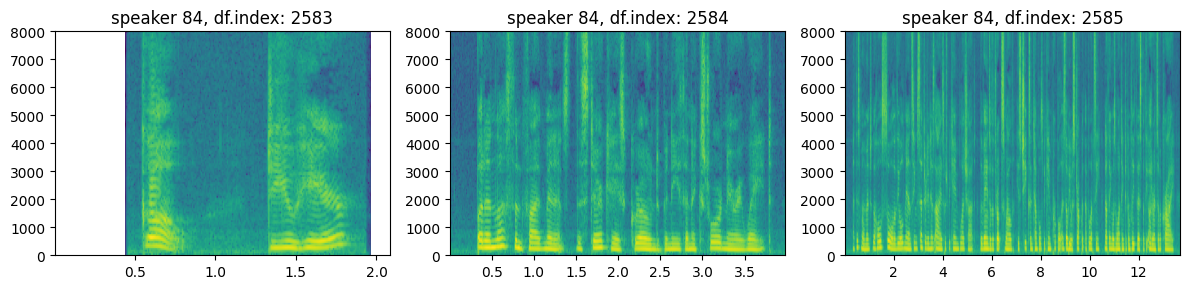

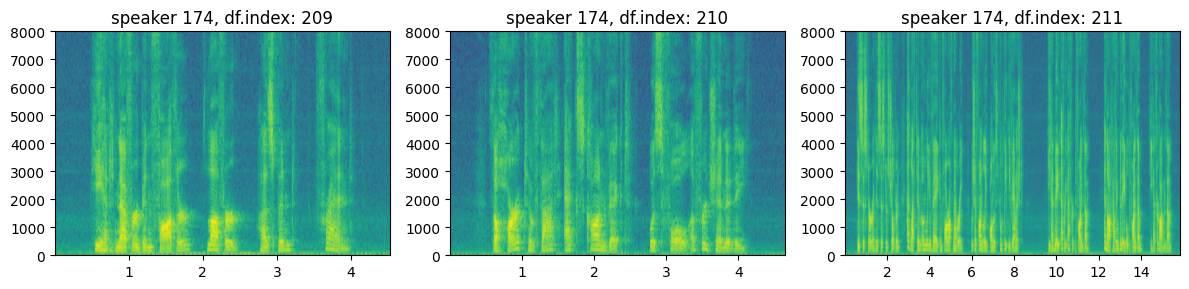

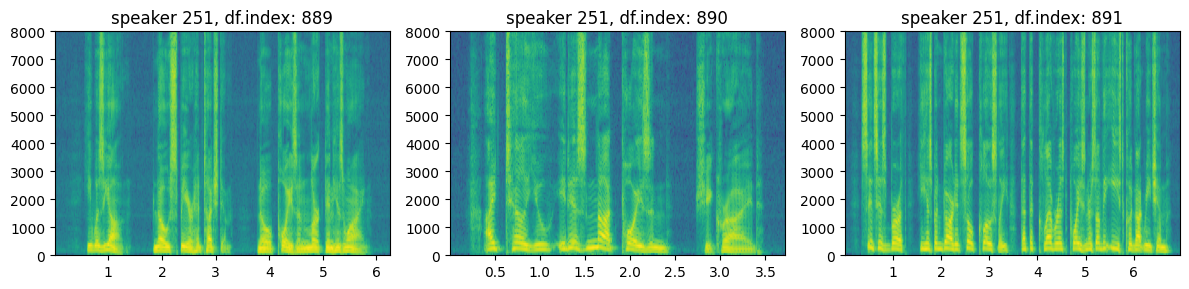

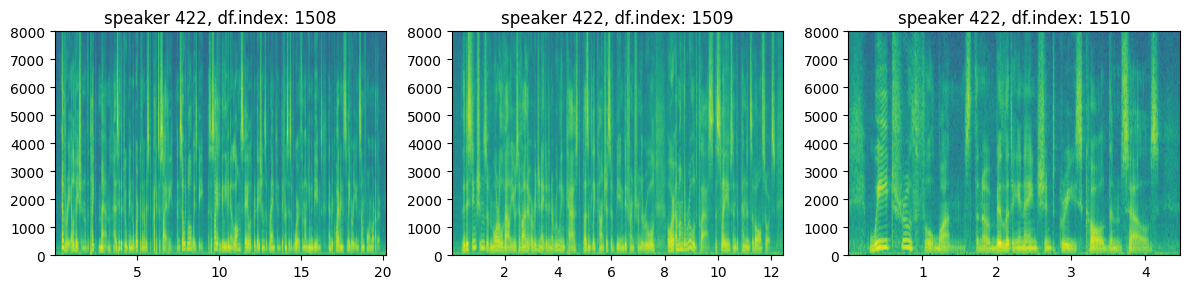

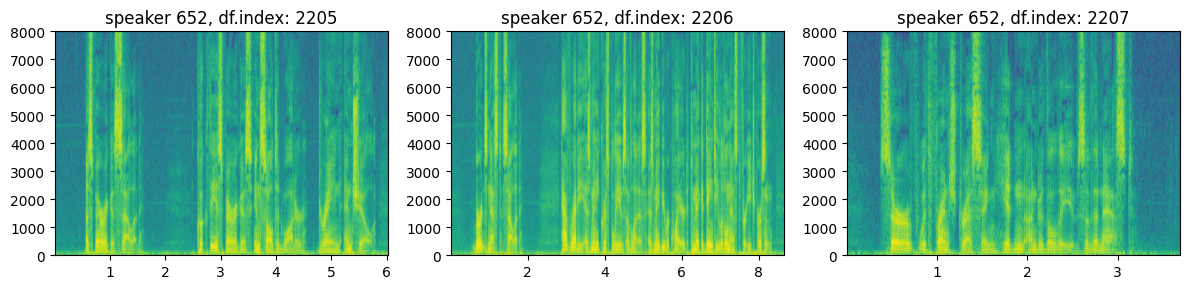

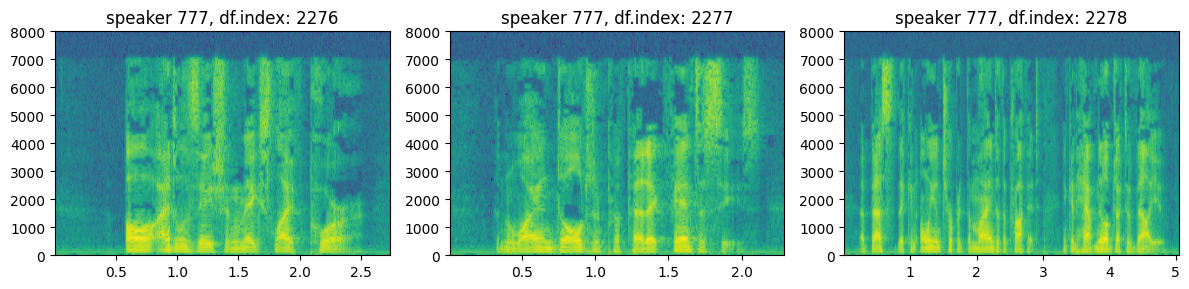

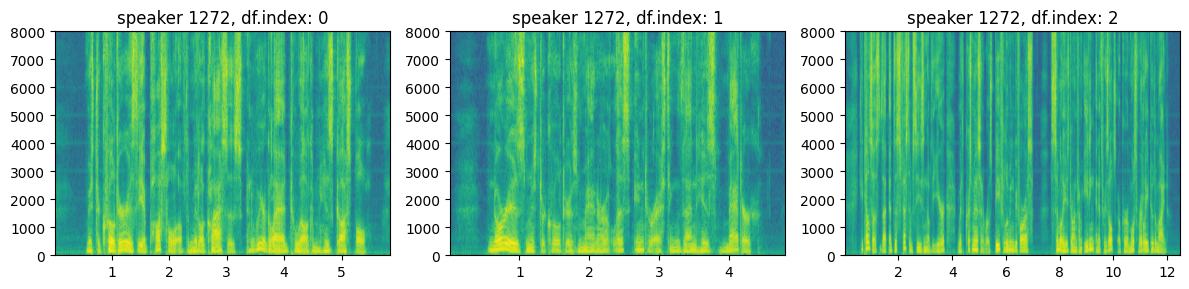

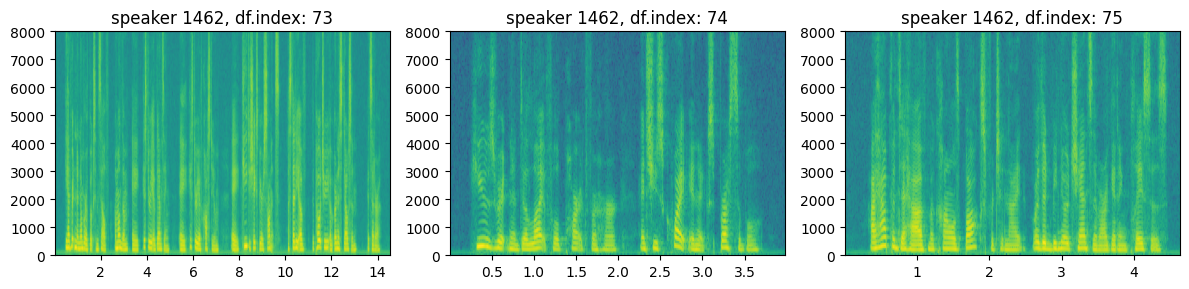

In [ ]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        ax[j].specgram(wave, Fs=sample_rate)
        ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

        plt.tight_layout()

Visualize MFCC spectrograms

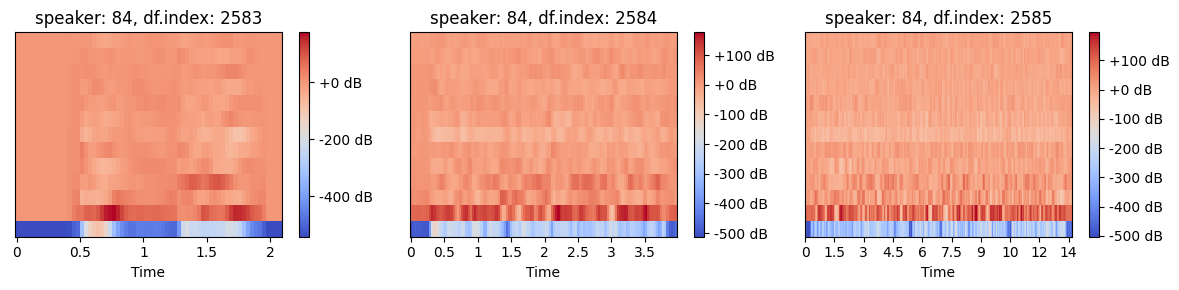

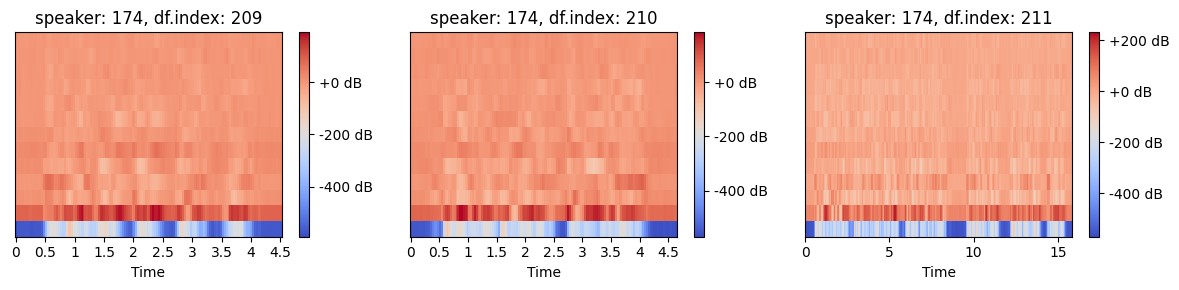

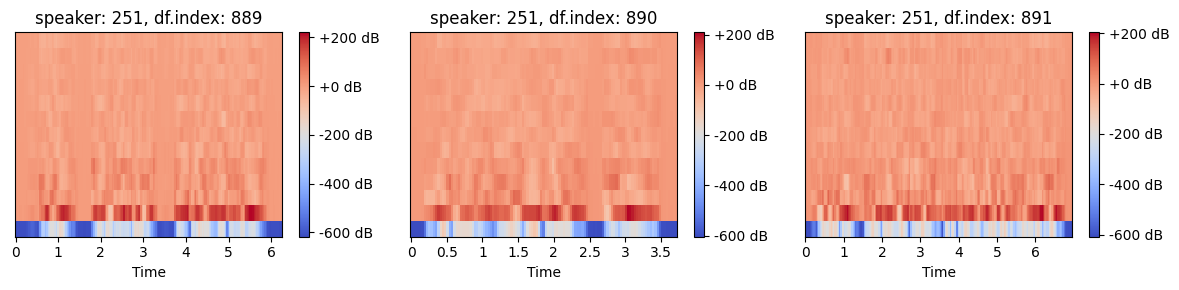

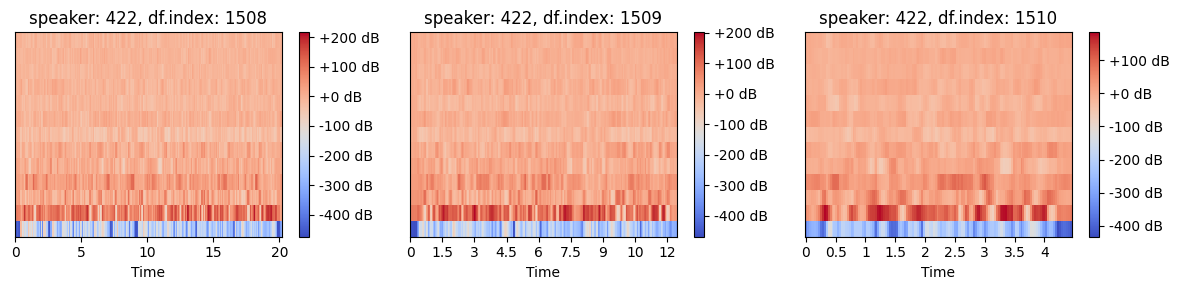

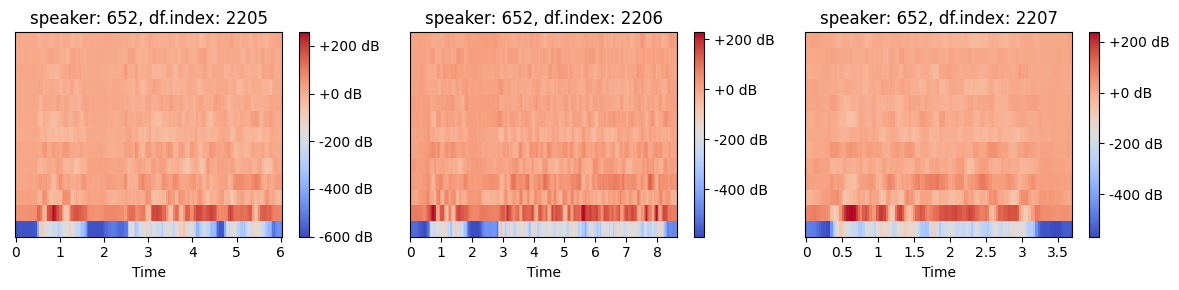

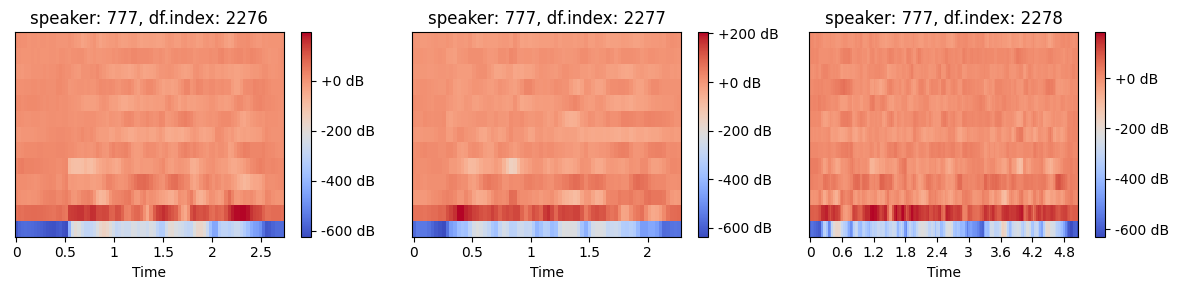

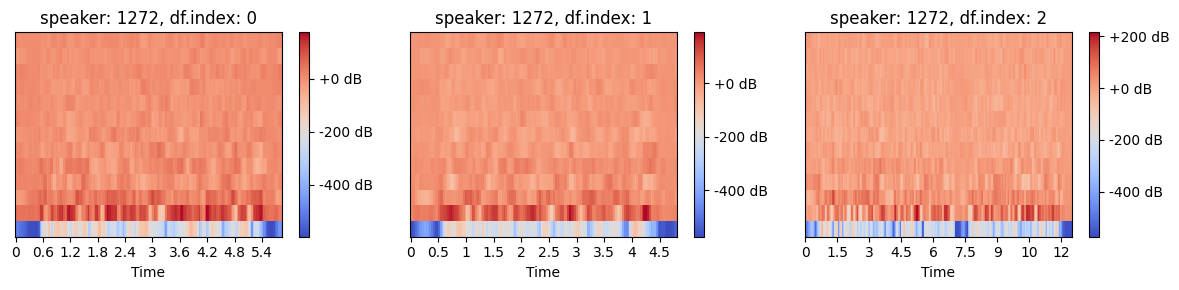

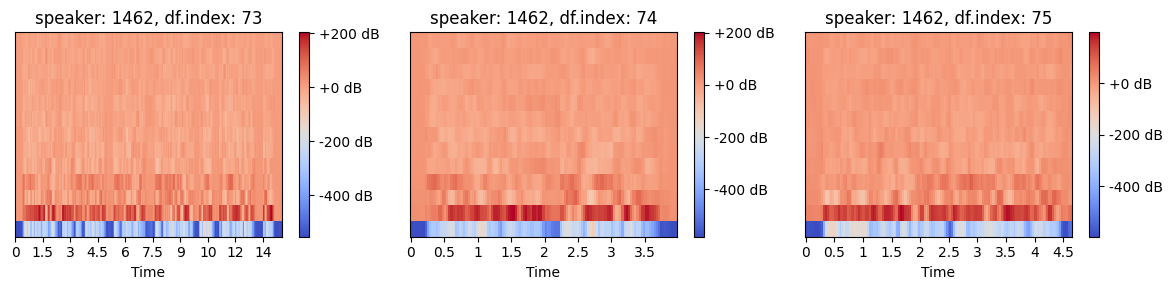

In [ ]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
        img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
        ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
        fig.colorbar(img, ax=ax[j], format="%+2.f dB")
    plt.tight_layout()

Visualization of each channel in MFCC

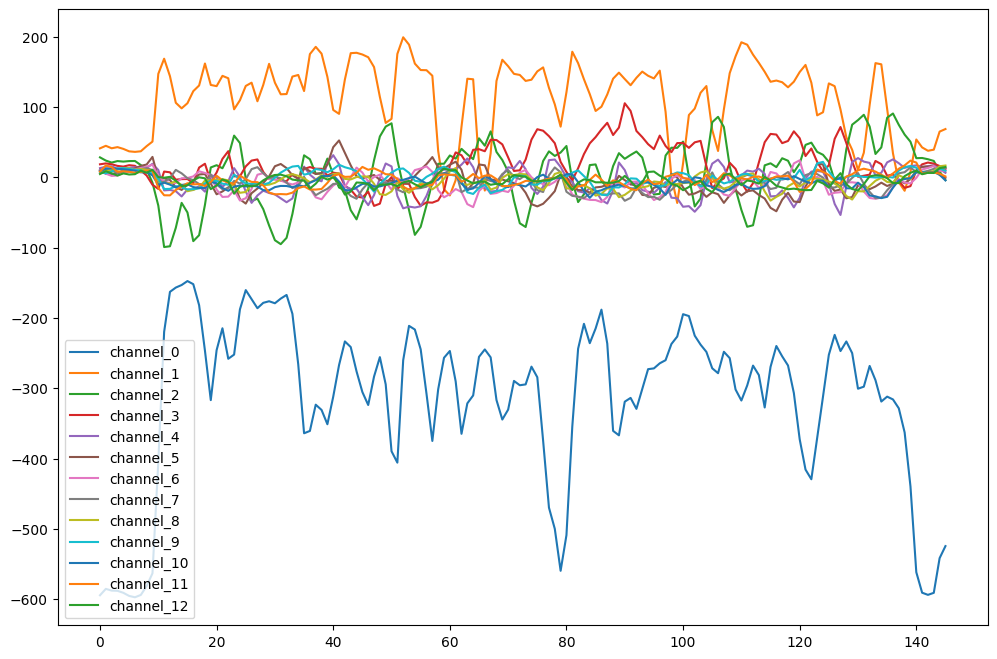

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(mfccs.shape[0]):
    plt.plot(mfccs[i,:], label=f"channel_{i}")
plt.legend()

# Preprocessing

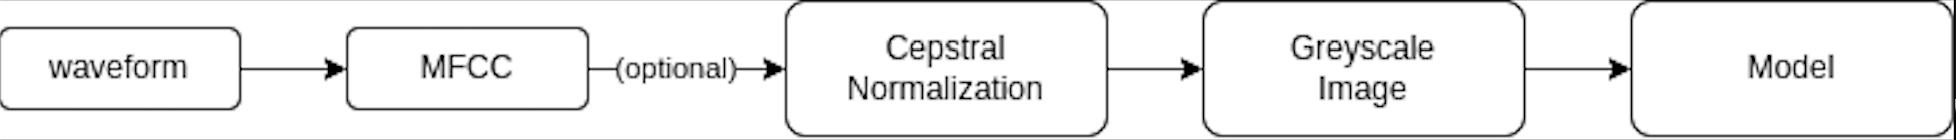

The preprocessing pipeline consists of the following steps:
1. Transform waveforms to MFCC
2. (optional) Perform Cepstral Normalization on the MFCC
3. Transform MFCC (2D-array) to a greyscale image

**Cepstral normalization** is the process of normalizing the MFCCs at every channel. The first channels of the MFCC carry the most important features; therefore, channels should not be mixed during normalization. At every channel, the values are normalized by subtracting the mean and dividing by the standard deviation: 
$$(X_{channel} - \mu_{channel})/\sigma_{channel} $$

Special consideration had to be taken during splitting of the data into train, validation, and test as well as during normalization. 

1. To ensure that each speaker_id is represent in each set, before splitting the audio samples were grouped by speaker id. Then the samples in each speaker_id are splitted in x% train, y% validation, z% test

2. To ensure there is no data leakage between training and other sets during normalization, **the Cepstral Normalizer only uses MFCCs from the training set during fitting.**

In [ ]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [ ]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [ ]:
def create_mfcc_databases(dataset, window_size, sample_rate, speaker_dict, number_spectral_coefficients):
    """
    Creates two databases from an audio dataset e.g. librispeech
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz    
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)
    
    """
    try:
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
    
    except FileNotFoundError:
        speaker_mfcc_db = pd.DataFrame(columns=["speaker_id", "mfcc_id"])
        mfcc_channel_db = pd.DataFrame(columns=["mfcc_id"]+[f"channel_{i}" for i in range(number_spectral_coefficients)]).set_index('mfcc_id')

        idx = 0

        print('Creating a database. Hold tight...')
        for i in tqdm(range(dataset.__len__())):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, window_size) # split waveforms into consistent chunks

            for chunk in splitted_waveform: # transform waveforms into MFCC spectrograms
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=sample_rate)

                speaker_mfcc_db.loc[idx, "speaker_id"] = speaker_dict[speaker_id]
                speaker_mfcc_db.loc[idx, "mfcc_id"] = idx

                for j in range(number_spectral_coefficients):
                    mfcc_channel_db.loc[idx, f"channel_{j}"] = 1
                    mfcc_channel_db.at[idx, f"channel_{j}"] = mfccs[j, :]
                
                idx += 1

        speaker_mfcc_db.to_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db.to_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')

    return speaker_mfcc_db, mfcc_channel_db

In [ ]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [ ]:
def get_datasets(base_dataset, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db, mfcc_channel_db = create_mfcc_databases(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict, number_spectral_coefficients=number_spectral_coefficients)

    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [ ]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

In [ ]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(dataset, 
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:00<00:00, 14.48it/s]


In [ ]:
train_set = Subset(mfcc_dataset_train, range(0, mfcc_dataset_train.__len__(), 10))
val_set = Subset(mfcc_dataset_val, range(0, mfcc_dataset_val.__len__(), 10))

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
train_loader.__len__(), val_loader.__len__()

In [ ]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(2039, 686, 703)

In [ ]:
train_loader.__len__(), val_loader.__len__()

(21, 7)

In [ ]:
for a, b in train_loader:
    break
print(a.shape)

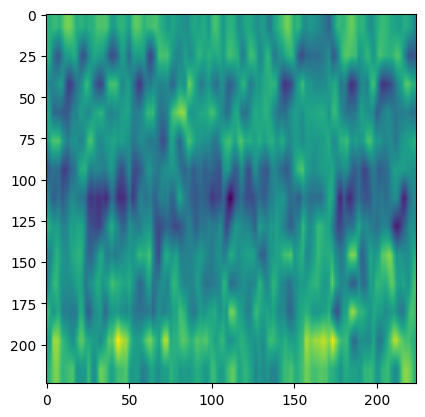

In [ ]:
plt.imshow(np.transpose(a[0].to('cpu').numpy(), [1, 2, 0]))

Visualize a random sample from the dataloader to verify it looks as expected

torch.Size([1, 13, 126]) torch.Size([])


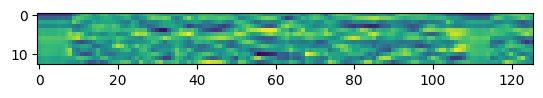

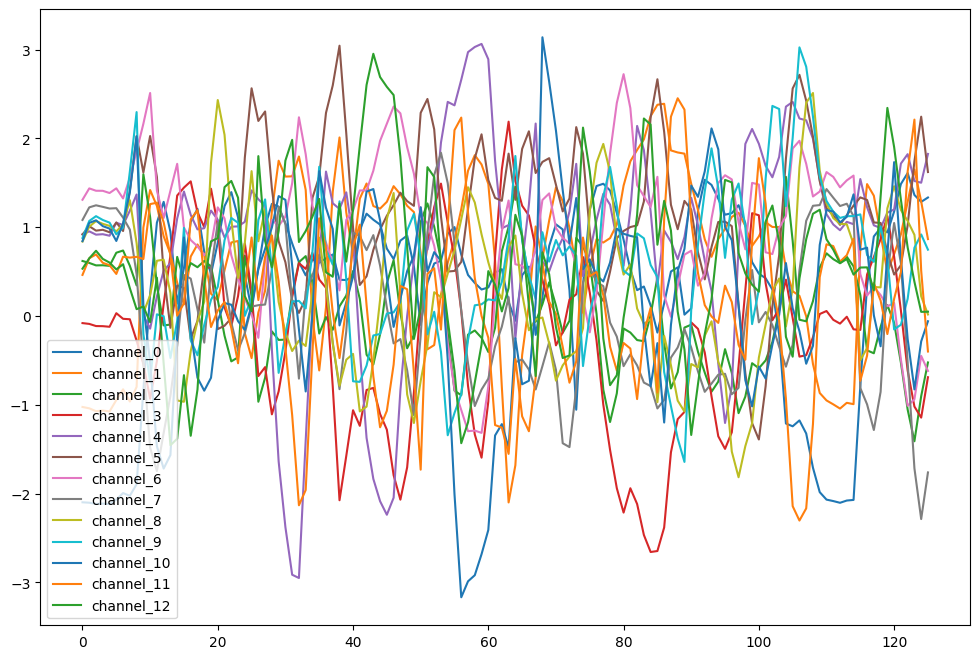

In [ ]:
random_sample = np.random.randint(0, 2300)
sample_mfcc, sample_speaker = mfcc_dataset_train.__getitem__(random_sample)

print(sample_mfcc.shape, sample_speaker.shape)

mfcc_arr = sample_mfcc.to('cpu').numpy().reshape(13, 126)
plt.figure()
plt.imshow(mfcc_arr)
plt.figure(figsize=(12, 8))
for i in range(mfcc_arr.shape[0]):
    plt.plot(mfcc_arr[i,:], label=f"channel_{i}")
plt.legend()

Plot above shows the normalized channels of the MFCC. Without normalization, each channel would have different orders of magnitude and each audio sample would have different range of values. 

C:\Users\William Hazen\AppData\Local\Temp\ipykernel_12140\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


torch.Size([1, 224, 224]) torch.Size([])


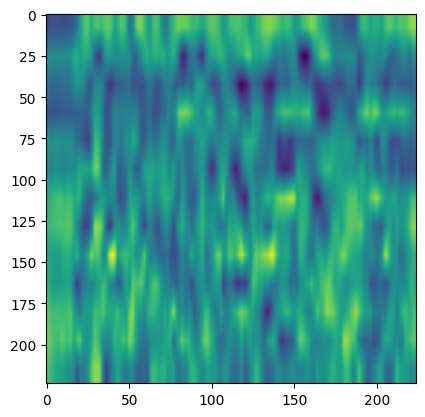

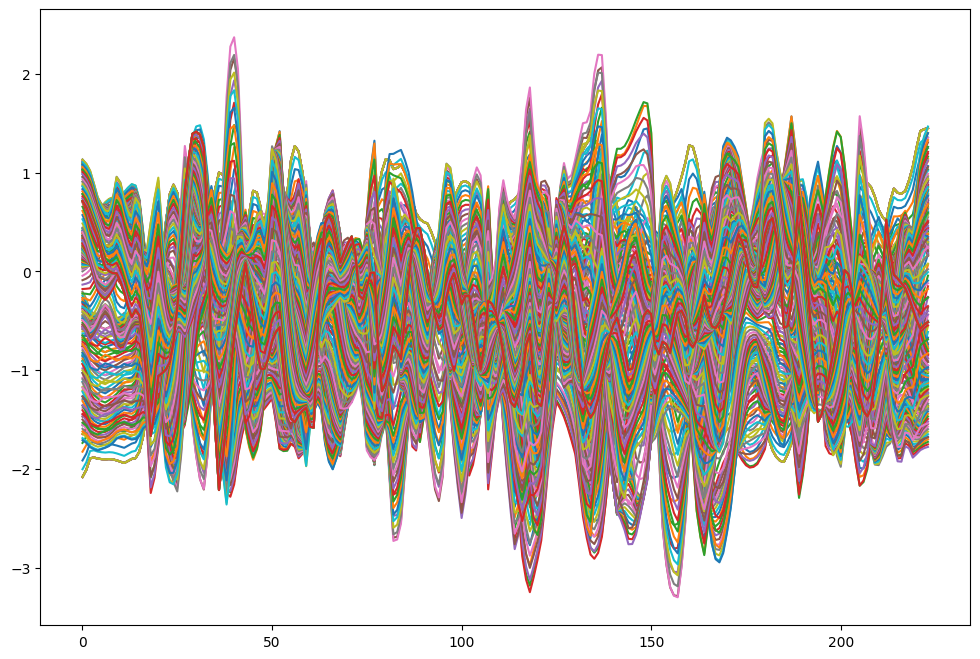

In [ ]:
random_sample = np.random.randint(0, 2300)
sample_mfcc, sample_speaker = mfcc_dataset_train.__getitem__(random_sample)

print(sample_mfcc.shape, sample_speaker.shape)

mfcc_arr = sample_mfcc.to('cpu').numpy().reshape(224, 224)
plt.figure()
plt.imshow(mfcc_arr)
plt.figure(figsize=(12, 8))
for i in range(mfcc_arr.shape[0]):
    plt.plot(mfcc_arr[i,:], label=f"channel_{i}")

In [ ]:
#Dataloaders with librispeech dataset
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

# AudioNet Base structure

Our group initially tried the pre-trained alexNet, modified the initial input and final output layer to match the input and output requirements of this task. 

After training for 35 epoches, the validation and test accuracy hovered around 50%, indicating pretrained alexNet may not be a good model for this audio classification task.

Our group speculated that alexNet was trained on ImageNet data, was tasked to classify the real-world pictures. In another word, the features captured by CNN in real-world photo/images and artificially generated audio MFCC diagrams are quite different. 

The AudioNet structure illustrated below was the final model. The size and number of conv layers were optimized based on the model performance (accuracy), training time, and model size (number of parameters). This final structure was found providing best accuracy while being relatively small in size.

The improvements over AlexNet include the use of Random ReLu activation functions, and the LogSoftmax at the final output layer of fully connected layer.



*   RReLu activation function: According to paper *Empirical Evaluation of Rectified Activations in Convolution Network* (https://arxiv.org/pdf/1505.00853v2.pdf), the randomized slope at negative value will consistently improve the performance of CNN network structure.
*   LogSoftmax: The properties of Logsoftmax versus tradition softmax will result in better numerical stability and heavier penalties on wrong predictions.Thus, to improve the overall performance of the AudioNet Structure.



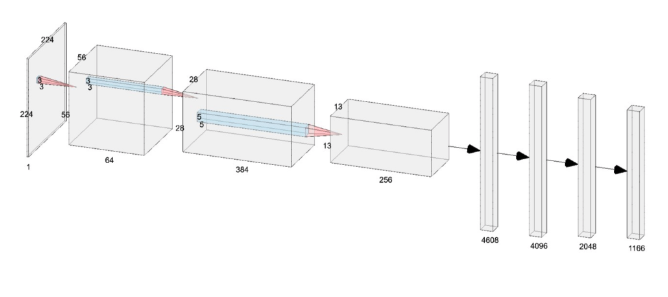

In [ ]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Training function and training commands

In [ ]:

subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))

net =  CustomNet(num_classes=output_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
#Train
trained_model, history = train_and_validate(net, epochs=10, batch_size = 64, lr=1e-4)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 2.7241, Accuracy: 43.5812%, 
		Validation : Loss : 0.7397, Accuracy: 80.0093%, Time: 440.8508s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.6044, Accuracy: 82.9548%, 
		Validation : Loss : 0.4025, Accuracy: 88.8361%, Time: 441.8106s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.3399, Accuracy: 89.9637%, 
		Validation : Loss : 0.4047, Accuracy: 89.0672%, Time: 444.2392s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.2364, Accuracy: 92.7554%, 
		Validation : Loss : 0.2605, Accuracy: 92.9149%, Time: 446.9260s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.1812, Accuracy: 94.3254%, 
		Validation : Loss : 0.1961, Accuracy: 94.6224%, Time: 440.2298s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.1451, Accuracy: 95.3719%, 
		Validation : Loss : 0.2367, Accuracy: 93.9599%, Time: 443.3254s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.1225, Accuracy: 96.0975%, 
		Validation : Loss : 0.2150, Accuracy: 94.7066%, Time: 443.3344s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.1055, Accuracy: 9

## Results

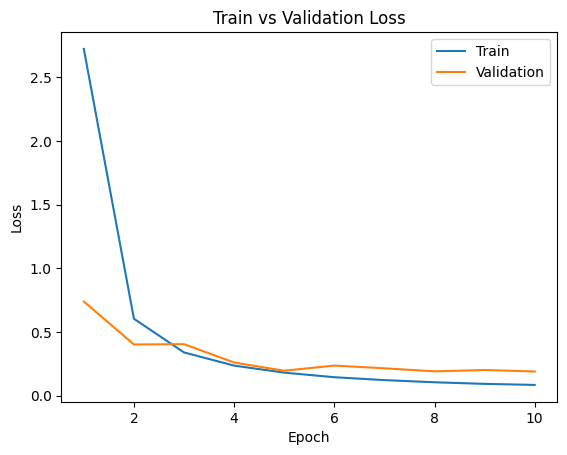

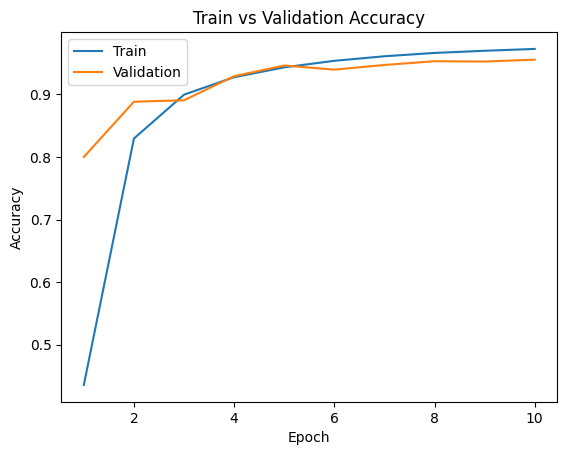

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

The training and validation accuracy and loss curve of AudioNet model on librispeech training/validation dataset indicated that the model performed very well while was being trained for 10 epoches under batch_size = 64, lr=1e-4. Our group did further increase the training epoches and the result suggested increasing in validation loss (over fitting) with no improvement in validation accuracy. 

## Test on Librispeech test dataset

Testing function and accuracy for AudioNet on Librispeech test dataset

In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')



In [ ]:
test_model(net, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 95 %


In [ ]:
#Saving the trained model

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\net.pth"
torch.save(net, path)

# Transfer Learning with VoxCeleb dataset

In [ ]:
#Re-call empty AudioNet Structure
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
'''
Load the pretrained  Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\net.pth')

In [ ]:
#Modify the last layer to number of celebs (classes) in new dataset
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(2048, 1252)

model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

## Train the transfer learnt model

In [ ]:
net =  model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

trained_model, history = train_and_validate(net, epochs=12, batch_size = 32, lr=1e-4)

Epoch: 1/12


C:\Users\David\AppData\Local\Temp\ipykernel_5824\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 3.8310, Accuracy: 36.2377%, 
		Validation : Loss : 2.6017, Accuracy: 52.3708%, Time: 222.7289s
Epoch: 2/12
Epoch : 002, Training: Loss: 2.1073, Accuracy: 55.1573%, 
		Validation : Loss : 2.2174, Accuracy: 59.0938%, Time: 221.2566s
Epoch: 3/12
Epoch : 003, Training: Loss: 1.6570, Accuracy: 62.1181%, 
		Validation : Loss : 2.0948, Accuracy: 61.9908%, Time: 221.5474s
Epoch: 4/12
Epoch : 004, Training: Loss: 1.4098, Accuracy: 66.4072%, 
		Validation : Loss : 2.0570, Accuracy: 63.4448%, Time: 209.7317s
Epoch: 5/12
Epoch : 005, Training: Loss: 1.2361, Accuracy: 69.3367%, 
		Validation : Loss : 2.0319, Accuracy: 64.5667%, Time: 209.1147s
Epoch: 6/12
Epoch : 006, Training: Loss: 1.1082, Accuracy: 71.7863%, 
		Validation : Loss : 2.0411, Accuracy: 65.1462%, Time: 213.6651s
Epoch: 7/12
Epoch : 007, Training: Loss: 1.0218, Accuracy: 73.4094%, 
		Validation : Loss : 2.0495, Accuracy: 65.8623%, Time: 226.2184s
Epoch: 8/12
Epoch : 008, Training: Loss: 0.9448, Accuracy: 7

## Results

Plot Train/Loss Curve

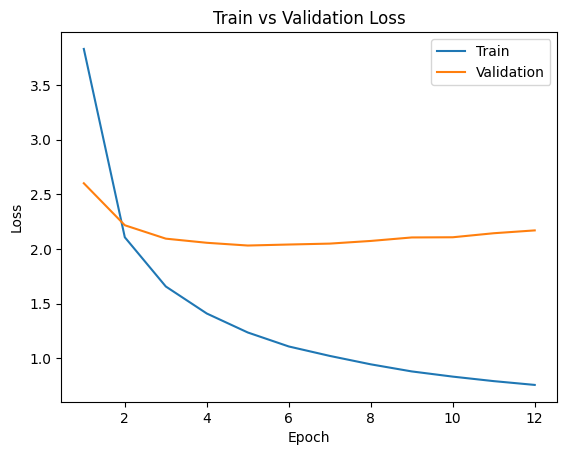

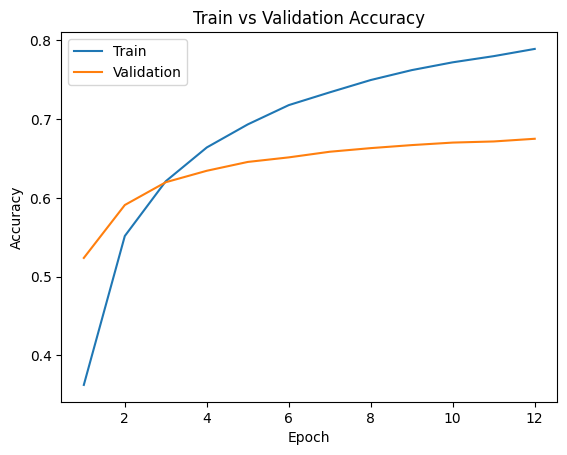

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

The performance of AudioNet on voxCeleb dataset it suggesting a bit lower accuracy compared to the librispeech dataset while epoch = 15, batch_size = 64, and lr = 1e-4. This was being expected as the voxCeleb dataset is much more noiser, many clips with multiple people talking and overlapping in addition to the background noise. 

In [ ]:
#Test the transfer learning model on vox celeb test dataset
test_model(model, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5824\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 67 %


In [ ]:
#Saving the transfer learning model on celeb+Sinisa dataset

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\transferred_model.pth"
torch.save(model, path)

Demo

In [ ]:
'''
Load the pretrained Trasfer Learnt AudioNet Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\transferred_model.pth')

In [ ]:
#Load the index-name file for voxceleb model
voxfile = r"F:\speaker_project\audio-speaker-recognition\notebooks\vox1_meta.csv"
vox_df = pd.read_csv(voxfile)

In [ ]:
#Creating a name list with its index and test run
name = []
for i in range(1251):

    name.append(str(vox_df.iloc[i])[64:].split('\\')[0])
name[1250]

'Zulay_Henao'

In [ ]:
#Demo helper functions
def print_name(speakers, predicted):
    actual = []
    model_output = []
    speakers.tolist()
    predicted.tolist()
    for spk in speakers:
        actual.append(name[spk-1])
    for pred in predicted:
        model_output.append(name[pred-1])


    dict = {"Actual":actual,"Predicted":model_output}
    return pd.DataFrame(dict)
    #print("Actual Celeberity in this demo batch are:", actual)
    #print("Model predictions are:", model_output)

def get_ith_batch_result(num):
    with torch.no_grad():
        cnt = 0
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            df = print_name(speakers, predicted)
            cnt += 1
            if cnt == num:
                break
    return df

In [ ]:
#Get the ith batch test_loader result comparision
result = get_ith_batch_result(240)
result

C:\Users\David\AppData\Local\Temp\ipykernel_2308\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Actual          Predicted
0        Eli_Wallach        Leslie_Mann
1  Izabella_Scorupco  Izabella_Scorupco
2               Cher               Cher
3    Brendan_Gleeson    Brendan_Gleeson
4      Mark_Sheppard      Mark_Sheppard
5         Rhys_Darby         Rhys_Darby
6    Michaela_Conlin    Michaela_Conlin
7     Monica_Raymund     Monica_Raymund
8        Hill_Harper     Sharlto_Copley
9          Brian_Cox          Brian_Cox

# Discussions

Overall, the model achieved adequent accuracy, below is the comparison of accuracy on different dataset: 

Librispeech:
- Train: 97.27%
- Validation: 95.56%
- Test: 95.22%

VoxCeleb:
- Train: 78.93%
- Validation: 67.51%
- Test: 67%

Librispeech dataset performed better as expected as the dataset is relatively clean since they are extracted from audio books. VoxCeleb has a lower accuracy as the dataset includes celebrities talking in different settings (e.g. interview, TV shows), and the audio samples include background noises and other speakers talking at the same time. 

Overall, the project allowed us to try out real data and apply them on  customized model. We were able to take audio data and convert it into images (something we are familiar with). With images as input, we were able to take what we learned in this class - Alexnet and transfer learning, and built a cutomized model on top of it to better suit our problem. 

During the project, we also learned how to use GitHub to collaborate and get some exposure to the industry's best practive. We also learned how pickled data can help speeding up the process, by doing so, we convert our data into bytestream, so that they can be easily loaded and processed in notebooks and networks. 

There are a few limitations to our mode. First, it requires relatively clean data to achieve a high accuracy such as the Librispeech test accuracy we observed. The librispeech dataset contains clean and structured audiobook samples. Therefore, if a user wants to record their voice for the upcoming conference, it needs to be recorded in a quiet place with no background noises. Additionally, each users use different microphones which might contribute more noise and lower the quality of the audio. The audio samples in VoxCeleb is a closer represnetation to the real world recordings where background noises and other speakers' voice are present. However, the test accuracy for VoxCeleb is lower. Second, it does not allow real time recognition. Third, it requires a large dataset to train. In practive, if one user wants to set up the voice recognition to unlock the door at home, the ideal situation is that the user only needs to input a short sentence (a very seconds of recording).

There are a few things that can be improved further. For example, the sample length can be increase from 4 seconds to observe how the model would react. The number of channels can also be increased from 13 to see if it would help the model to capture more useful features. With longer sample length and potentially a high number of channels, we can also test out if the number of training samples can be reduced.

# Citation

LibriSpeech ASR corpus: 
https://www.openslr.org/12

VoxCeleb: https://arxiv.org/pdf/1706.08612v2.pdf

Model architecture:
http://alexlenail.me/NN-SVG/AlexNet.html